## Physically Informed Neural Network

In [1]:
import tensorflow as tf
from tensorflow.keras.constraints import min_max_norm
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from random import *
from tqdm.notebook import tqdm

############| SETTINGS |############
a = 0; b = 1;
N = 50; #Nuerons in the Hidden Layer
N_EvEl = 101; #Spacing of the evaluation function
itmax = 10000;
tol = 1e-4;
gamma = tf.Variable(1e1,dtype=np.float32)
def f(x):
    return (np.pi**2)*np.sin(np.pi*x);
####################################

#Pnts = np.linspace(a,b,N_EvEl)

Pnts = np.array([0.0])
Pnts = np.random.uniform(a,b,N_EvEl)
Pnts = np.append(Pnts,1.0)
Pnts = np.sort(Pnts)

u = tf.keras.Sequential([
    tf.keras.layers.Dense(N,input_dim=1, activation='tanh'),#Hidden Layer
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(1,use_bias=False)#10 leyers weights.
])

#We create an evaluation mesh
mesh = tf.Variable([[point] for point in Pnts]);
F = tf.cast(tf.Variable([[-f(point)] for point in Pnts]),dtype=np.float32);
#Defining the lost function
def LSQEnergy(weights):
    with tf.GradientTape() as gtape2:
        with tf.GradientTape() as gtape:
            uh = u(mesh, training=True)
        du_dx = gtape.gradient(uh, [mesh])
    #We use TF Gradient Tape to compute grad uh
    d2u_dx2 = gtape2.gradient(du_dx,[mesh])
    Energy = (1/N_EvEl)*tf.reduce_sum(tf.square(d2u_dx2-F));
    #Adding B.C using penalty method idea;
    Energy = Energy + gamma*(tf.abs(u(mesh)[0][0])+tf.abs(u(mesh)[0][-1]))
    return Energy;

In [2]:
print(u(mesh).shape)
print(LSQEnergy(u.trainable_weights))

(102, 1)
tf.Tensor(44.500187, shape=(), dtype=float32)


In [3]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

# Iterate over the batches of a dataset.
for it in tqdm(range(itmax)):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        Loss = LSQEnergy(u.trainable_weights)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(Loss, u.trainable_weights)
    res = sum([tf.norm(grad) for grad in gradients]);
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, u.trainable_weights))
    if res <= tol:
        break;
    if it%(itmax/10) == 0:
        print("[It. {}] Loss function value {} and residual {}.".format(it,Loss,res))
print("Loss function value {} and residual {}.".format(Loss,res))

  0%|          | 0/10000 [00:00<?, ?it/s]

[It. 0] Loss function value 44.500186920166016 and residual 114.15145111083984.
[It. 1000] Loss function value 0.14932215213775635 and residual 85.06873321533203.
[It. 2000] Loss function value 0.747861921787262 and residual 74.80812072753906.
[It. 3000] Loss function value 0.6518247723579407 and residual 78.17658996582031.
[It. 4000] Loss function value 0.39561185240745544 and residual 69.97735595703125.
[It. 5000] Loss function value 0.2685604691505432 and residual 80.0799331665039.
[It. 6000] Loss function value 0.44717398285865784 and residual 81.0343017578125.
[It. 7000] Loss function value 0.2159377634525299 and residual 71.62036895751953.
[It. 8000] Loss function value 0.08249646425247192 and residual 77.45816802978516.
[It. 9000] Loss function value 0.15538577735424042 and residual 74.95482635498047.
Loss function value 0.6700527667999268 and residual 85.69718933105469.


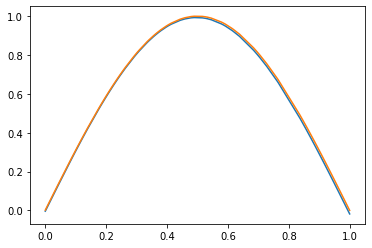

In [5]:
plt.plot(mesh.numpy(),u(mesh).numpy())
plt.plot(mesh.numpy(),np.sin(np.pi*mesh.numpy()))